## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [25]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [26]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [27]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [28]:
from sklearn.model_selection import train_test_split

fmnist_dataset_train, fmnist_dataset_val = train_test_split(fmnist_dataset_train, train_size=50000)


In [29]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)
val_loader = torch.utils.data.DataLoader(fmnist_dataset_val, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

In [30]:
len(fmnist_dataset_test)

10000

In [31]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

Путем исследований, я выяснила, что модель с одной функцией активации давала всего ~0.80 accuracy score, поэтому я сразу попробовала модель с двумя функциями активации. Остальные параметры и слои были взяты из прошлой части за основу.

In [32]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 128),
            nn.BatchNorm1d(128, eps=1e-3, momentum=1-0.9),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 60),
            nn.ReLU(),
            nn.Linear(60, num_classes),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [33]:
from sklearn.metrics import accuracy_score

def event_loop(name, net, train_loader, val_loader, optimizer, n_epoch, criterion):
    loss_history = []
    accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    
    for i in range(n_epoch):
        net.train()

        accuracy_batches=[]
        loss_batches=[]
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion(predictions, y_batch)
            
            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_batches.append(loss.cpu().detach().numpy())

            # Accuracy
            test_accuracy = accuracy_score(predictions.cpu().argmax(axis=1), y_batch.cpu())
            accuracy_batches.append(test_accuracy)

        loss_history.append(np.mean(loss_batches))
        accuracy_history.append(np.mean(accuracy_batches))
        
        
        # Validating
        net.eval()
        with torch.no_grad():
            val_acc_batches=[]
            val_loss_batches=[]
            for X_val, Y_val in val_loader:    
                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                val_predictions = net.forward(X_val)
                val_loss = criterion(val_predictions, Y_val)
                val_loss_batches.append(val_loss.cpu().detach().numpy())
                val_acc = accuracy_score(val_predictions.cpu().argmax(axis=1), Y_val.cpu())
                val_acc_batches.append(val_acc)
        
        val_loss_history.append(np.mean(val_loss_batches))
        val_accuracy_history.append(np.mean(val_acc_batches))
        
        clear_output(wait=True)
        
        plt.figure(figsize=(9, 7))
        plt.title(f"Training and validation loss {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Loss")
        plt.plot(loss_history, 'b', label='train loss')
        plt.plot(val_loss_history, 'r', label='validation loss')
        plt.legend()
        
        clear_output(wait=True)
        plt.figure(figsize=(9, 7))
        plt.title(f"Training and validation accuracy {name}")
        plt.xlabel("#epoch")
        plt.ylabel("Accuracy")
        plt.plot(accuracy_history, 'b', label='train accuracy')
        plt.plot(val_accuracy_history, 'r', label='validation accuracy')
        plt.legend()
        
        plt.show()
        
        print('Current loss: %f' % np.mean(val_loss_batches), 'Current validation loss: %f' % np.mean(val_acc_batches)) 

In [34]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 60]           7,740
              ReLU-7                   [-1, 60]               0
            Linear-8                   [-1, 10]             610
        LogSoftmax-9                   [-1, 10]               0
Total params: 109,086
Trainable params: 109,086
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
-------------------------------------------

Your experiments come here:

In [35]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-1, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 25
optimizer_state = {}
loss_func = nn.NLLLoss()

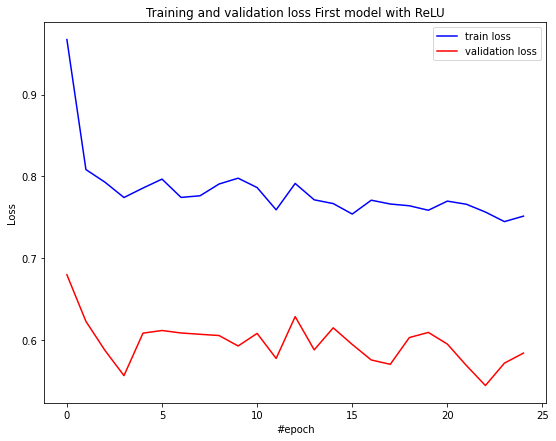

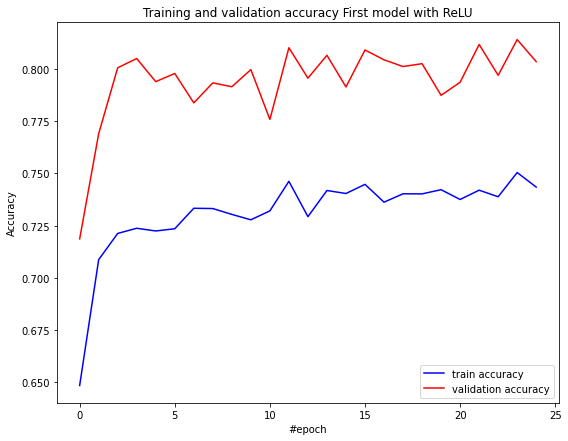

Current loss: 0.583760 Current validation loss: 0.803418


In [36]:
event_loop(name='First model with ReLU', net=model, train_loader=train_loader, val_loader=val_loader, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [37]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.803125


Опять же методом проб и ошибок, перебрав параметры оптимизатора приходим к тому, что learning_rate нужно уменьшить, сделаем это:

In [38]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 20
optimizer_state = {}
loss_func = nn.NLLLoss()

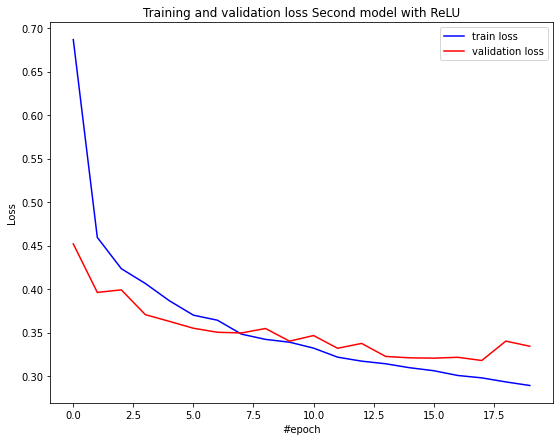

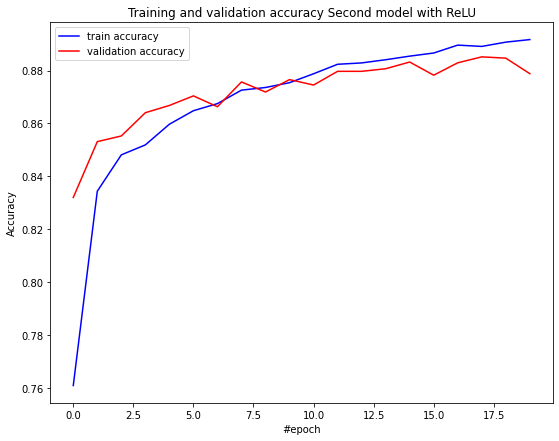

Current loss: 0.334251 Current validation loss: 0.878809


In [39]:
event_loop(name='Second model with ReLU', net=model, train_loader=train_loader, val_loader=val_loader, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [40]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.8826171875


Видно, что стало как раз идеально, мы построили отличную модель.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

С лекций мы знаем, что BatchNorm и Dropout помогают от переобучения, так что попробуем для начала их отключить. 

In [41]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.ReLU(),
            nn.Linear(60, num_classes),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [42]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 60]           7,740
              ReLU-5                   [-1, 60]               0
            Linear-6                   [-1, 10]             610
        LogSoftmax-7                   [-1, 10]               0
Total params: 108,830
Trainable params: 108,830
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [43]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 25
optimizer_state = {}
loss_func = nn.NLLLoss()

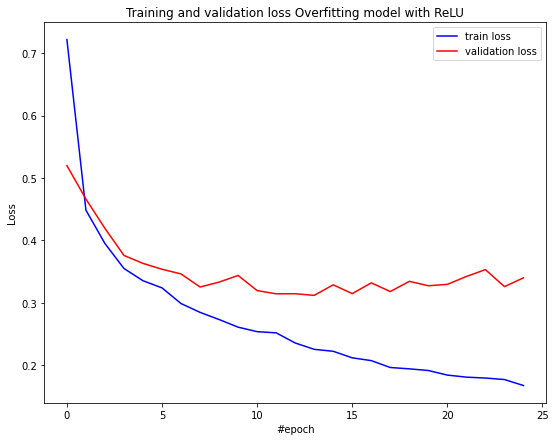

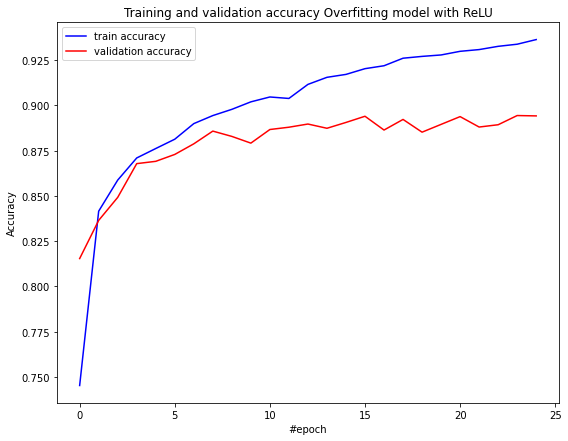

Current loss: 0.340212 Current validation loss: 0.894238


In [44]:
event_loop(name='Overfitting model with ReLU', net=model, train_loader=train_loader, val_loader=val_loader, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [45]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.89169921875


С первой попытки получилось построить переобучение. Это переобучение потому что пока train loss продолжает стремительно уменьшатся, validate loss остается на месте, это значит что все обучение с этого момента происходит впустую и модель просто подстраивается под тренировочную выборку

А что если уменьшить размер тренировочных данных?

In [46]:
fmnist_dataset_train_new, fmnist_dataset_val_new = train_test_split(fmnist_dataset_train, train_size=30000)

In [47]:
train_loader_new = torch.utils.data.DataLoader(fmnist_dataset_train_new, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
val_loader_new = torch.utils.data.DataLoader(fmnist_dataset_val_new, 
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=2)

In [48]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 25
optimizer_state = {}
loss_func = nn.NLLLoss()

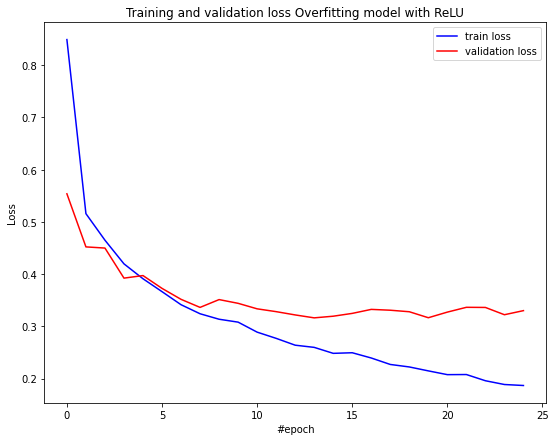

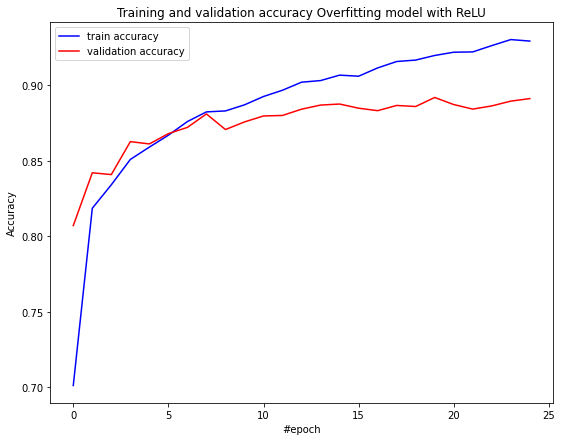

Current loss: 0.330038 Current validation loss: 0.891268


In [49]:
event_loop(name='Overfitting model with ReLU', net=model, train_loader=train_loader_new, val_loader=val_loader_new, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [50]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.88154296875


Переобучение осталось примерно таким же, но чуть уменьшилось accuracy test

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

Сначала добавим BatchNorm

In [51]:
class FixedNeuralNetworkBatchNorm(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 128),
            nn.BatchNorm1d(128, eps=1e-3, momentum=1-0.9),
            nn.ReLU(),
            nn.Linear(128, 60),
            nn.ReLU(),
            nn.Linear(60, num_classes),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [52]:
torchsummary.summary(FixedNeuralNetworkBatchNorm().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 60]           7,740
              ReLU-6                   [-1, 60]               0
            Linear-7                   [-1, 10]             610
        LogSoftmax-8                   [-1, 10]               0
Total params: 109,086
Trainable params: 109,086
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [53]:
model = FixedNeuralNetworkBatchNorm().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 25
optimizer_state = {}
loss_func = nn.NLLLoss()

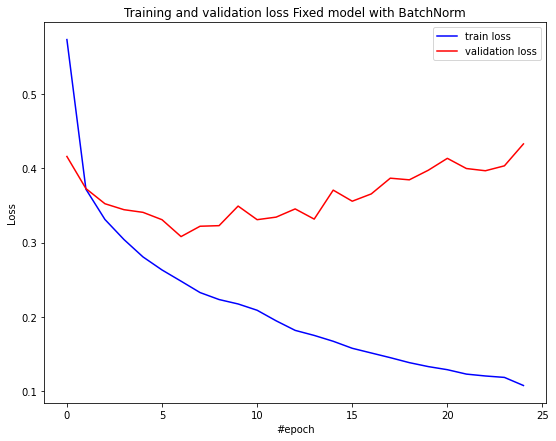

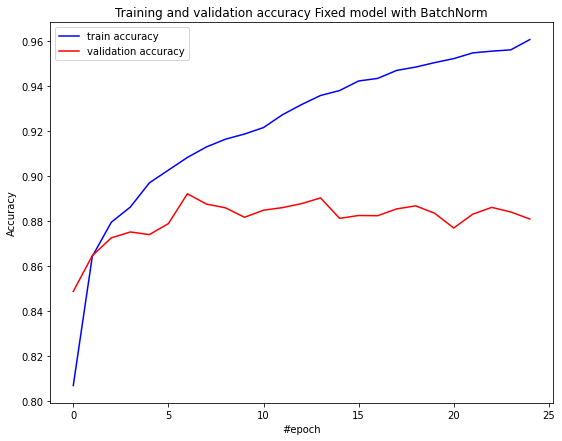

Current loss: 0.433157 Current validation loss: 0.880957


In [54]:
event_loop(name='Fixed model with BatchNorm', net=model, train_loader=train_loader, val_loader=val_loader, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [55]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.88486328125


Видно, что BatchNorm вообще не помог. Тогда попробуем добавить только DropOut

In [56]:
class FixedNeuralNetworkDropOut(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 60),
            nn.ReLU(),
            nn.Linear(60, num_classes),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [57]:
torchsummary.summary(FixedNeuralNetworkDropOut().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 60]           7,740
              ReLU-6                   [-1, 60]               0
            Linear-7                   [-1, 10]             610
        LogSoftmax-8                   [-1, 10]               0
Total params: 108,830
Trainable params: 108,830
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
----------------------------------------------------------------


In [58]:
model = FixedNeuralNetworkDropOut().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 25
optimizer_state = {}
loss_func = nn.NLLLoss()

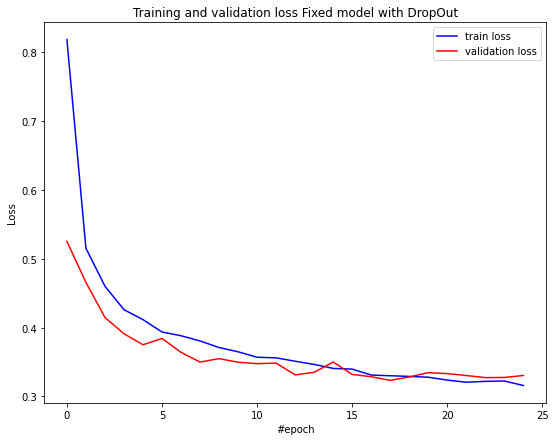

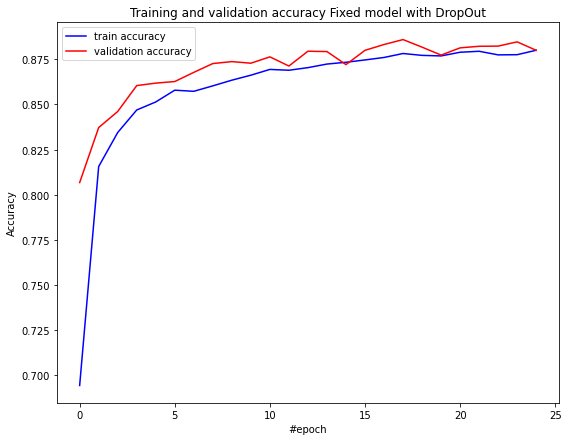

Current loss: 0.330460 Current validation loss: 0.879980


In [59]:
event_loop(name='Fixed model with DropOut', net=model, train_loader=train_loader, val_loader=val_loader, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [60]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.87890625


Круто! DropOut очень заметно помог от переобучения, теперь попробуем объединить с BatchNorm

In [61]:
class FixedNeuralNetworkDropOutBatchNorm(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 128),
            nn.BatchNorm1d(128, eps=1e-3, momentum=1-0.9),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 60),
            nn.ReLU(),
            nn.Linear(60, num_classes),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [62]:
torchsummary.summary(FixedNeuralNetworkDropOutBatchNorm().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
       BatchNorm1d-3                  [-1, 128]             256
              ReLU-4                  [-1, 128]               0
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 60]           7,740
              ReLU-7                   [-1, 60]               0
            Linear-8                   [-1, 10]             610
        LogSoftmax-9                   [-1, 10]               0
Total params: 109,086
Trainable params: 109,086
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
-------------------------------------------

In [63]:
model = FixedNeuralNetworkDropOut().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 25
optimizer_state = {}
loss_func = nn.NLLLoss()

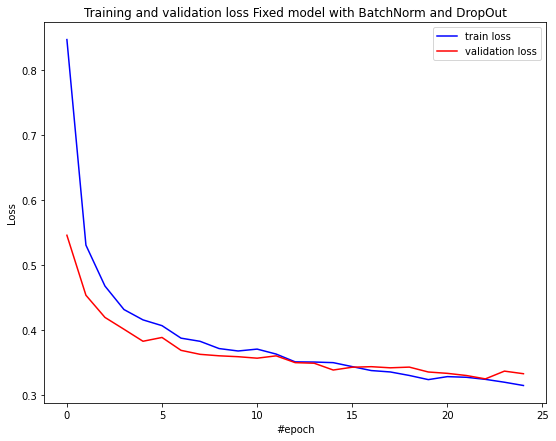

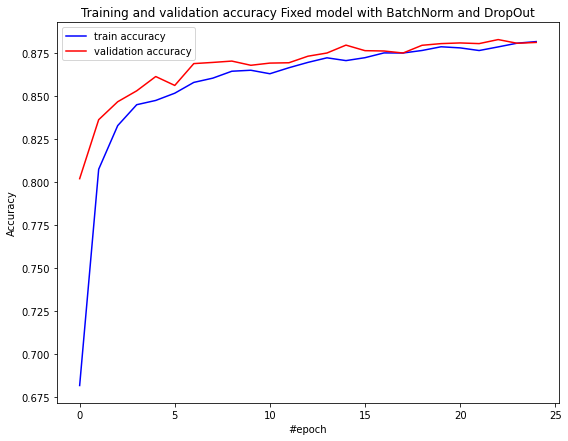

Current loss: 0.333177 Current validation loss: 0.881348


In [64]:
event_loop(name='Fixed model with BatchNorm and DropOut', net=model, train_loader=train_loader, val_loader=val_loader, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [65]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.88251953125


Проверим может ли быть переобучение, увеличив количество эпох. Это может дать больший accuracy

In [66]:
model = FixedNeuralNetworkDropOut().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.99, 0.99), eps=1e-5)
n_epoch = 35
optimizer_state = {}
loss_func = nn.NLLLoss()

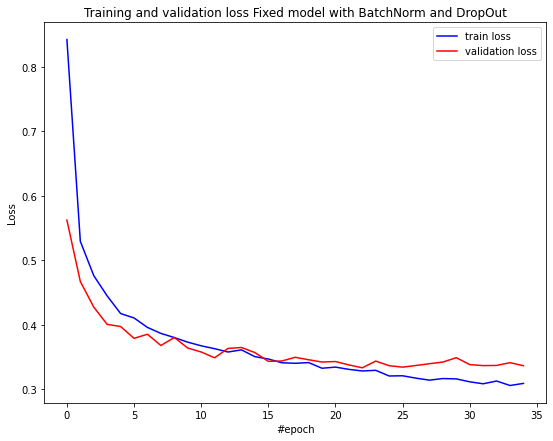

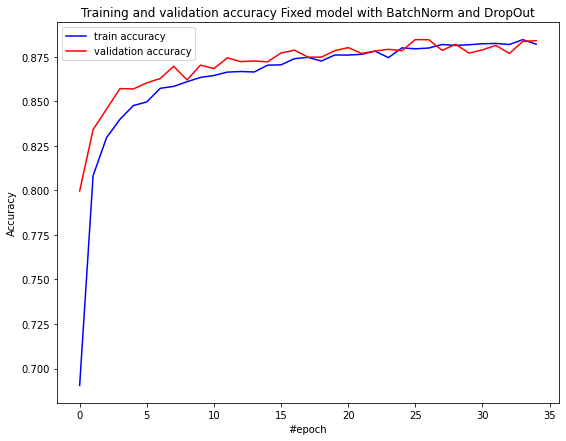

Current loss: 0.336623 Current validation loss: 0.884180


In [67]:
event_loop(name='Fixed model with BatchNorm and DropOut', net=model, train_loader=train_loader, val_loader=val_loader, optimizer=opt, n_epoch=n_epoch, criterion=nn.NLLLoss())

In [68]:
model.eval()
test_acc_batches = []
for X_test, Y_test in test_loader:    
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    test_predictions = model.forward(X_test)
    test_acc = accuracy_score(test_predictions.cpu().argmax(axis=1), Y_test.cpu())
    test_acc_batches.append(test_acc)

print(f'Accuracy score of model on test {np.mean(test_acc_batches)}')

Accuracy score of model on test 0.88046875


Переобучение не случилось, значит пофиксили модель и с помощью увеличения эпох немного увеличили accuracy

### Conclusions:
_Write down small report with your conclusions and your ideas._

Была проделана работа по обучению и переобучению модели и построенна лучшая модель которая дает accuracy score = 0.88. В самой первой части сделан вывод, что одного слоя активации не достаточно для досчтижения высоких результатов, а два слоя ReLU как раз хватает. Так же я сделала вывод, что learning rate достаточно важный параметр, который может как резко поднять, так и уменьшить score.  
Во второй и третьей части главные выводы, которые были получены - это то, что Dropout очень эффективный метот борьбы с переобучением. Так то BatchNorm тоже должен работать достаточно эффективно, но на нашиъ данных он не показал никаких улучшений (возможно это связано с тем, что его нужно было юзать в комплекте с какими то другими методами).  
Поэтому в дальнейшем очень важно следить за переобучением, потому что это говорит об эффективности построенной нами модели. Хороший способ это сделать - это использовать валидационную выборку всегда и наблюдать по графикам как ведет себя ее loss и accuracy.